In [20]:
import numpy as np
import pandas as pd 
import os
from numpy import float32
import gc
import pickle
from sklearn.externals import joblib
from xgboost.sklearn import XGBClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn import metrics

In [ ]:
os.getcwd()

In [ ]:
promoted_content = pd.read_csv('promoted_content.csv')
document_category = pd.read_csv('documents_categories.csv')
document_topic = pd.read_csv('documents_topics.csv')
document_entity = pd.read_csv('documents_entities.csv')
events_data = pd.read_csv('events.csv')
clicks_train  = pd.read_csv('clicks_train.csv')
clicks_test = pd.read_csv('clicks_test.csv')

In [ ]:
clicks_train.shape

In [ ]:
clicks_test.shape

In [ ]:
def splitDataFrameIntoSmaller(dfs, chunkSize = 15000000):
    dataframes = list()
    chunk_number = len(dfs) // chunkSize + 1
    for i in range(chunk_number):
        dataframes.append(dfs[i*chunkSize:(i+1)*chunkSize])
    return dataframes

In [ ]:
split_train_frame = splitDataFrameIntoSmaller(clicks_train)

In [ ]:
chunk_frame = split_train_frame[0]

In [ ]:
chunk_frame.head()

# Events - File 0

In [ ]:
merged_df_with_Event = pd.DataFrame(events_data)

In [ ]:
merged_df_with_Event.drop(['uuid','timestamp','document_id'],axis=1,inplace=True)

In [ ]:
merged_df_with_Event['Country']=merged_df_with_Event['geo_location'].str[0:2]

In [ ]:
merged_df_with_Event.drop(['geo_location'],axis=1,inplace=True)

In [ ]:
merged_df_with_Event.head(1)

In [ ]:
merged_df_with_Events = pd.merge(chunk_frame,merged_df_with_Event,how='left',on=(['display_id']))

In [ ]:
merged_df_with_Events['Country'] = pd.Categorical.from_array(merged_df_with_Events.Country).labels
merged_df_with_Events = merged_df_with_Events.query("Country == Country")

In [ ]:
merged_df_with_Events['platform'] = pd.Categorical.from_array(merged_df_with_Events.platform).labels
merged_df_with_Events['platform'] = pd.to_numeric(merged_df_with_Events['platform'], errors='ignore')

In [ ]:
merged_df_with_Events.head(1)

# Promoted Content - File 1

In [ ]:
merged_df = pd.merge(merged_df_with_Events,promoted_content,how='left',on='ad_id')

# Document Category - File 2

In [ ]:
average_category_confidenceLevel = pd.DataFrame(document_category.groupby(['document_id'])['confidence_level'].mean()).reset_index()

In [ ]:
merged_df_with_CL_Cat = pd.merge(merged_df,average_category_confidenceLevel,how='left',on='document_id')

In [ ]:
merged_df_with_CL_Cat.to_csv('merged_df_with_CL_Cat.csv',index=None)

In [ ]:
merged_df_with_CL_Cat = merged_df_with_CL_Cat[np.isfinite(merged_df_with_CL_Cat['confidence_level'])]

In [ ]:
merged_df_with_CL_Cat['confidence_level'] = merged_df_with_CL_Cat['confidence_level'].map('{:,.3f}'.format)

In [ ]:
merged_df_with_CL_Cat[['confidence_level']] = merged_df_with_CL_Cat[['confidence_level']].astype(float)

# Document Topics - File 3

In [ ]:
average_topic_confidenceLevel = pd.DataFrame(document_topic.groupby(['document_id'])['confidence_level'].mean()).reset_index()

In [ ]:
merged_df_with_CL_Top = pd.merge(merged_df_with_CL_Cat,average_topic_confidenceLevel,how='left',on='document_id')

In [ ]:
merged_df_with_CL_Top = merged_df_with_CL_Top[np.isfinite(merged_df_with_CL_Top['confidence_level_y'])]

In [ ]:
merged_df_with_CL_Top['confidence_level_y'] = merged_df_with_CL_Top['confidence_level_y'].map('{:,.3f}'.format)

In [ ]:
merged_df_with_CL_Top[['confidence_level_y']] = merged_df_with_CL_Top[['confidence_level_y']].astype(float)

# Document Entities - File 4

In [ ]:
average_entity_confidenceLevel = pd.DataFrame(document_entity.groupby(['document_id'])['confidence_level'].mean()).reset_index()

In [ ]:
merged_df_with_CL_Ent = pd.merge(merged_df_with_CL_Top,average_entity_confidenceLevel,how='left',on='document_id')

In [ ]:
merged_df_with_CL_Ent.to_csv("merged_df_with_CL_Ent.csv")

In [ ]:
gc.collect()

In [2]:
merged_df_with_CL_Ent = pd.read_csv("merged_df_with_CL_Ent.csv")

In [3]:
merged_df_with_CL_Ent = merged_df_with_CL_Ent[np.isfinite(merged_df_with_CL_Ent['confidence_level'])]

In [4]:
merged_df_with_CL_Ent['confidence_level'] = merged_df_with_CL_Ent['confidence_level'].map('{:,.3f}'.format)

In [5]:
merged_df_with_CL_Ent[['confidence_level']] = merged_df_with_CL_Ent[['confidence_level']].astype(float)

In [6]:
merged_df_with_CL_Ent[['platform']] = merged_df_with_CL_Ent[['platform']].astype(int)

In [7]:
merged_df_with_CL_Ent.drop(['Unnamed: 0'],axis=1,inplace=True)

In [8]:
merged_df_with_CL_Ent.shape

(12977781, 11)

In [9]:
merged_df_with_CL_Ent.to_csv("Document_Metadata.csv", index=False)

In [10]:
document_metadata = pd.read_csv("Document_Metadata.csv")

In [11]:
document_metadata.head()

,display_id,ad_id,clicked,platform,Country,document_id,campaign_id,advertiser_id,confidence_level_x,confidence_level_y,confidence_level
0,1,42337,0,2,208,938164,5969,1499,0.495,0.312,0.626
1,1,139684,0,2,208,1085937,17527,2563,0.495,0.363,0.445
2,1,144739,1,2,208,1337362,18488,2909,0.495,0.242,0.855
3,1,156824,0,2,208,992370,7283,1919,0.495,0.318,0.352
4,1,279295,0,2,208,1670176,27524,1820,0.203,0.022,0.249


# Model Creation

In [22]:
X = [x for x in merged_df_with_CL_Ent.columns if x not in ['display_id','clicked']]
x = merged_df_with_CL_Ent[X]

In [23]:
Y = ['clicked']
y = merged_df_with_CL_Ent[Y]
y = np.ravel(y)

In [24]:
Xtrain, X_test, y_train, y_test = train_test_split(x,y,test_size=0.3, random_state=0)

In [25]:
model = XGBClassifier(max_depth=3,n_estimators=400, learning_rate=0.02)

In [26]:
train_model = model.fit(Xtrain,y_train)

In [27]:
print(model.score(Xtrain,y_train))

0.806508839394


In [39]:
pred = train_model.predict_proba(X_test)

array([[ 0.77918243,  0.2208176 ],
       [ 0.77562046,  0.22437955],
       [ 0.79270226,  0.20729774],
       ..., 
       [ 0.78842616,  0.21157384],
       [ 0.79900199,  0.20099799],
       [ 0.81000674,  0.18999329]], dtype=float32)

In [41]:
preds = model.predict_proba(X_test)[:,1]
fpr,tpr, _ = roc_curve(y_test,preds)

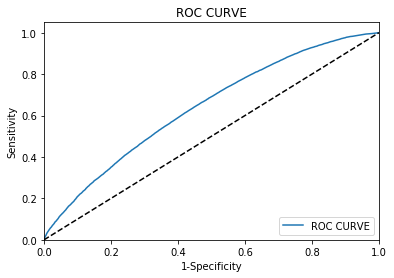

In [42]:
import matplotlib.pylab as plt

plt.figure()
plt.plot(fpr,tpr,label= "ROC CURVE")
plt.plot([0,1],[0,1],'k--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()